## STUDY 1 :  WHICH STOCK TO BUY/SELL ?!

In [21]:
#https://github.com/huseinzol05/Stock-Prediction-Models/blob/master/misc/which-stock.ipynb
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from IPython.display import display
import yfinance as yf
import seaborn as sns
sns.set()
import random


import requests
from bs4 import BeautifulSoup

In [2]:
# =================================================================
# I. Select the desired period of time AND the ticker stocks
# =================================================================
periodTime = '10y'
# ori_name = ['PE500.PA', 'CW8.PA', 'EEM']
# ori_name = ['FDX', 'KEY', 'SAP', 'TSN', 'TTE', 'AKE.PA', 'TGT', 'ITT', 'JNJ', 'KO', 'YUM', 'BAC', 'SNA', 'MCD', 'SWK', 'INTC', 'UNM', 'AFL', 'RIO', 'ADM', 'JPM', 'SAMS.PA', 'PNW']
# ori_name = ['AL', 'KER.PA', 'OR', 'RI.PA', 'RIO']
ori_name = ['FDX', 'KEY', 'SAP', 'TSN', 'AKE.PA', 'TGT', 'ITT', 'JNJ', 'KO', 'YUM', 'BAC', 'SNA', 'MCD', 'SWK', 'INTC', 'UNM', 'AFL', 'RIO', 'ADM', 'JPM', 'SAMS.PA', 'PNW']
# ori_name = ['BBY', 'BLk', 'LOW', 'MSFT', 'PNC', 'PFE', 'PG', 'TROW', 'USB', 'UFPI']
len_ori_name = len(ori_name)


In [3]:
# =================================================================
# II. Download and prepare the data to create "dataDF"
# =================================================================
# Get Data for each ticker for the desired period, then keep only the "close" column and add data result to "dataDF"
dataDF = pd.DataFrame({})
df = [[]]*len_ori_name
for x in range(len_ori_name):
    df[x]  = yf.download(tickers=ori_name[x], period=periodTime)
    time.sleep(100/1000)
    df[x].drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis=1, inplace=True)
    dataDF['Close'+str(x)]  =  df[x]

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [4]:
# =================================================================
# II. Download the dividends and compute the yearly diviends yield
# =================================================================
# Define the ticker symbol
Ticker_DividendTable = pd.DataFrame({})
cntDividend = -1
for ticker_idx in ori_name:
    cntDividend = cntDividend + 1
    CurrentTicker = yf.Ticker(str(ticker_idx))
    
    CurrentTickerHistory = CurrentTicker.history(period = periodTime)
    CurrentTickerHistory.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
    CurrentTickerHistory = CurrentTickerHistory.tz_localize(None)
    
    CurrentCloseTickerHistory = CurrentTicker.history(period = periodTime)
    CurrentCloseTickerHistory.drop(['Open', 'High', 'Low', 'Volume'], axis=1, inplace=True)
    CurrentCloseTickerHistory = CurrentCloseTickerHistory.tz_localize(None)

    # Compute the number of dividends by year
    dividends_by_year = CurrentTickerHistory.groupby(pd.Grouper(freq='Y')).sum()
    dividends_by_year.drop(['Stock Splits'], axis=1, inplace=True)
    
    # Compute the average stock price by year
    prices_by_year = CurrentCloseTickerHistory.groupby(pd.Grouper(freq='Y')).mean()
    prices_by_year.drop(['Stock Splits', 'Dividends'], axis=1, inplace=True)

    # Compute Dividend yield by year
    currentDividendYield = dividends_by_year['Dividends'].div(prices_by_year['Close'])
    
    # Save Dividend yield by year for each tickers
    Ticker_DividendTable[ticker_idx] = currentDividendYield

In [5]:
Ticker_DividendTable.reset_index(inplace=True)

In [6]:
# =================================================================
# II. Interpole the yearly dividend for getting the daily dividend yield
# =================================================================

# Create a new dataframe with daily datetime index
start_date = Ticker_DividendTable['Date'].iloc[0] 
end_date   = Ticker_DividendTable['Date'].iloc[-1]
daily_dates = pd.date_range(start=start_date, end=end_date, freq='D')

df_daily = pd.DataFrame({'Date': daily_dates})

# Merge the yearly dividend yield dataframe with the daily dataframe
df_daily = pd.merge(df_daily, Ticker_DividendTable, on='Date', how='left')

# interpolate the dividend yield for missing values
for ori_nameIdx in ori_name:
    df_daily[ori_nameIdx] = df_daily[ori_nameIdx].interpolate(method='linear')

df_daily.drop(['Date'], axis=1, inplace=True)

In [7]:
returns = dataDF.pct_change()
returns.reset_index(inplace=True)
returns.drop(['Date'], axis=1, inplace=True)

In [8]:
# =================================================================
# III. Compute the data "combine"
# returns is the sum of the dividend and pct_change()
# =================================================================
returns = dataDF.pct_change()
returns.reset_index(inplace=True)
returns.drop(['Date'], axis=1, inplace=True)

returns.add(df_daily)
mean_daily_returns = returns.mean()
volatilities = returns.std()

combine = pd.DataFrame({'Returns': mean_daily_returns * 252,
                       'Volatility': volatilities * 252})

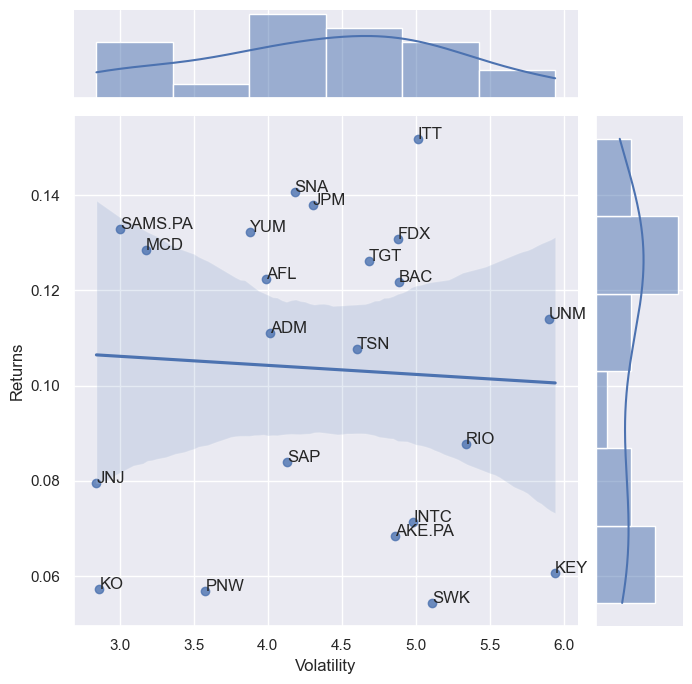

In [9]:
# =================================================================
# IV. PLOT the BUY (TOP) / SELL (BOTTOM) area for the differents 
# tickers based on their returns and volatility over the 
# specified period of time. 
# =================================================================
sns.set(style="darkgrid", color_codes=True)
g = sns.jointplot(x = "Volatility", y = "Returns", kind="reg", data=combine, height = 7)
# g.plot_joint(sns.kdeplot, color="r", zorder=1, levels=4)

for i in range(combine.shape[0]):
    plt.annotate(ori_name[i], (combine.iloc[i, 1], combine.iloc[i, 0]))
    

## 2. PORTFOLIO OPTIMIZATION USING SHARPE RATIO ON A MONTERCARLO SIMULATION

In [10]:
#https://github.com/huseinzol05/Stock-Prediction-Models/blob/master/simulation/portfolio-optimization.ipynb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [11]:
# =================================================================
# I. Create the Covariance Matrix: "cov_matrix"
# =================================================================
returns = dataDF.pct_change()
mean_daily_returns = returns.mean()
# mean_daily_returns = [mean_daily_returns[i] + dividendYield[i]/252 for i in range(len(mean_daily_returns))]

cov_matrix = returns.cov()

In [12]:
# =================================================================
# II. MONTECARLO SIMULATION FOR num_portfolios TIMES
# =================================================================
#set number of runs of random portfolio weights for the Montecarlo Simulation
num_portfolios = 300000

#set up array to hold results
results = np.zeros((4+len(ori_name)-1,num_portfolios))

# Get the weights of the portofolios based on the cov_matrix. 
for i in range(num_portfolios):
    #select random weights for portfolio holdings
    weights = np.random.random(cov_matrix.shape[0])
    
    #rebalance weights to sum to 1
    weights /= np.sum(weights)
    
    #calculate portfolio return and volatility
    portfolio_return = np.sum(mean_daily_returns * weights) * 252 
    portfolio_std_dev = np.sqrt(np.dot(weights.T,np.dot(cov_matrix, weights))) * np.sqrt(252)
    
    #store results in results array
    results[0,i] = portfolio_return
    results[1,i] = portfolio_std_dev
    results[2,i] = results[0,i] / results[1,i]
    
    #iterate through the weight vector and add data to results array
    for j in range(len(weights)):
        results[j+3,i] = weights[j]

In [13]:
# =================================================================
# III. CREATE the Panda Dataframe "results_frame"
# =================================================================
# Add 3 elements to the list "ori_name". They are going to be the new columns of the pd.DataFrame results_frame
ori_name.insert(0, 'ret')
ori_name.insert(1, 'stdev')
ori_name.insert(2, 'sharpe')
results_frame = pd.DataFrame(results.T, columns=ori_name)
results_frame

,ret,stdev,sharpe,FDX,KEY,SAP,TSN,AKE.PA,TGT,ITT,...,MCD,SWK,INTC,UNM,AFL,RIO,ADM,JPM,SAMS.PA,PNW
0,0.105452,0.184561,0.571365,0.013960,0.031830,0.054451,0.089396,0.050252,0.005362,0.005544,...,0.068527,0.012016,0.085421,0.083433,0.056943,0.036344,0.005635,0.079407,0.045318,0.013355
1,0.103259,0.167266,0.617334,0.019357,0.004621,0.061727,0.032681,0.086526,0.041641,0.031912,...,0.040621,0.030392,0.055089,0.026840,0.007853,0.062503,0.076676,0.037682,0.079695,0.070581
2,0.102633,0.175483,0.584858,0.050342,0.029170,0.068178,0.042554,0.038477,0.028504,0.018776,...,0.033284,0.065650,0.033651,0.056403,0.066460,0.059073,0.058575,0.003007,0.063587,0.036701
3,0.102904,0.179652,0.572799,0.078656,0.019672,0.083865,0.030991,0.001252,0.028687,0.037863,...,0.004134,0.027354,0.090591,0.079582,0.061199,0.016408,0.056480,0.083717,0.077951,0.070671
4,0.101400,0.175088,0.579136,0.042124,0.017248,0.056686,0.019437,0.027653,0.032591,0.056627,...,0.054978,0.066542,0.063086,0.021124,0.073755,0.026228,0.074045,0.047640,0.064972,0.073441
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299995,0.106374,0.184097,0.577815,0.027854,0.062099,0.065441,0.043584,0.014641,0.083377,0.057500,...,0.048346,0.035732,0.078960,0.039498,0.038810,0.015773,0.031577,0.046101,0.052799,0.033021
299996,0.104973,0.200364,0.523914,0.025815,0.082732,0.034917,0.035801,0.085623,0.044301,0.001614,...,0.044634,0.040324,0.026894,0.089636,0.078099,0.025153,0.000010,0.060754,0.024450,0.019372
299997,0.105079,0.193810,0.542176,0.027094,0.077316,0.060282,0.063902,0.071697,0.040648,0.069366,...,0.083052,0.012021,0.025437,0.069865,0.028057,0.021650,0.048072,0.016197,0.003217,0.029085
299998,0.107246,0.179773,0.596563,0.023262,0.005564,0.013392,0.009424,0.034964,0.052552,0.042936,...,0.068780,0.053169,0.066287,0.061016,0.048436,0.021276,0.062063,0.067915,0.057294,0.050483


In [14]:
# =================================================================
# IV. GET some parameter for further optimization
# =================================================================
#locate position of portfolio with highest Sharpe Ratio
max_sharpe_port = results_frame.iloc[results_frame['sharpe'].idxmax()]
#locate positon of portfolio with minimum standard deviation
min_vol_port = results_frame.iloc[results_frame['stdev'].idxmin()]
#locate positon of portfolio with maximum return
max_return_port = results_frame.iloc[results_frame['ret'].idxmax()]

In [15]:
# =================================================================
# V. GET my portfolio RETURN and VOLATILITY
# --> Specified the weights of the stocks. 
# =================================================================
# weights = np.asarray([0.27423193, 0.10040135, 0.099712307, 0.072519979, 0.04448233, 0.038179127, 0.034203516, 0.031970639, 0.030059788, 0.029962706, 0.02938732, 0.029330492, 0.029160007, 0.026770852, 0.022665009, 0.022352454, 0.022226958, 0.018878826, 0.009994672, 0.009109098, 0.008888889, 0.007584206, 0.007548689])
# # weights = [weights[i] for i in newOrderIndex]
# #calculate annualised portfolio return
# my_portfolio_return = round(np.sum(mean_daily_returns * weights) * 252,2)
# #calculate annualised portfolio volatility
# my_portfolio_std_dev = round(np.sqrt(np.dot(weights.T,np.dot(cov_matrix, weights))) * np.sqrt(252),2)
# [my_portfolio_return, my_portfolio_std_dev]

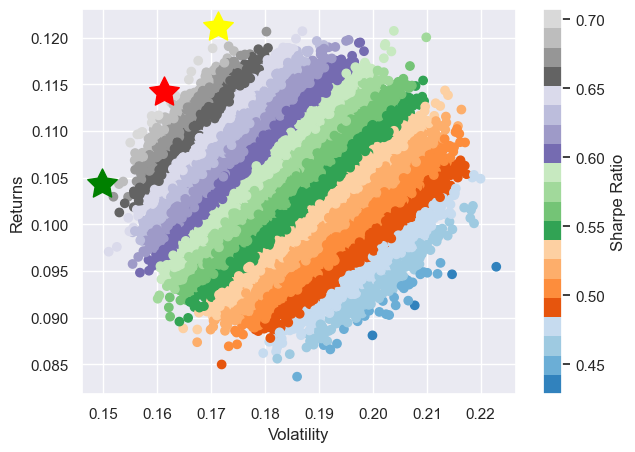

In [16]:
# =================================================================
# VI. PLOT the results of the Montecarlo simulation.
# Each point correspond to a different weight of stocks
# A star correspond to a portfolio which have been 
# optimized for some constraints. 
# =================================================================

#create scatter plot coloured by Sharpe Ratio
plt.figure(figsize = (7, 5))
plt.scatter(results_frame.stdev,results_frame.ret,c=results_frame.sharpe,cmap='tab20c')

cbar = plt.colorbar()
cbar.set_label('Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Returns')

# plot green star to highlight position of minimum variance portfolio
plt.scatter(min_vol_port[1],min_vol_port[0],marker=(5,1,0),color='green',s=500)
# plot yellow star to highlight position of maximum return portfolio
plt.scatter(max_return_port[1],max_return_port[0],marker=(5,1,0),color='yellow',s=500)
# plot red star to highlight position of portfolio with highest Sharpe Ratio
plt.scatter(max_sharpe_port[1],max_sharpe_port[0],marker=(5,1,0),color='red',s=500)
# # Plot my current portfolio and its distribution
# plt.scatter(my_portfolio_std_dev, my_portfolio_return,marker=(5,1,0),color='purple',s=500)

plt.show()

# ROUGE  : Maximise le ratio de Sharpe 
# JAUNE  : Maximise le returns
# VERT   : Minimise la volatilité
# VIOLET : Mon Portfolio Actuel

In [17]:
type(max_sharpe_port)
max_sharpe_port.name = "Maximize Sharpe Ratio"
min_vol_port.name = "Minimize Volatility"
max_return_port.name = "Maximize Portfolio Return"
final = pd.concat([max_sharpe_port, min_vol_port, max_return_port], axis=1)
final

,Maximize Sharpe Ratio,Minimize Volatility,Maximize Portfolio Return
ret,0.114163,0.104281,0.121164
stdev,0.161364,0.149769,0.171372
sharpe,0.707485,0.696276,0.707025
FDX,0.077914,0.017134,0.100075
KEY,0.005281,0.005506,0.005543
SAP,0.090152,0.063067,0.001617
TSN,0.032108,0.091099,0.057612
AKE.PA,0.016378,0.057712,0.010659
TGT,0.043784,0.048775,0.069651
ITT,0.017276,0.003853,0.031252


In [18]:
final.sort_values(by=['Maximize Sharpe Ratio'], inplace=True)
final['Maximize Sharpe Ratio'].tail(8)

FDX        0.077914
SAP        0.090152
MCD        0.097486
SAMS.PA    0.098022
YUM        0.101878
ret        0.114163
stdev      0.161364
sharpe     0.707485
Name: Maximize Sharpe Ratio, dtype: float64